In [1]:
# intersection pct > n (better way)

In [2]:
from glob import glob
from collections import defaultdict

import pandas as pd
import geopandas as gpd

In [3]:
def read_gdf(file_path, encoding):
    gdf = gpd.read_file(file_path, encoding=encoding)
    return gdf


def gdf2df(gdf):
    return pd.DataFrame(gdf)


read_gdf_with_cp949 = lambda file_path: read_gdf(file_path, "cp949")
read_shp = lambda file_path: gdf2df(read_gdf_with_cp949(file_path))

In [4]:
def read_excel(file_path, params):
    return pd.read_excel(file_path, **params)


read_excel_params = {
    "index_col": None,
    "header": 1,
    "converters": {"시도코드": str, "시군구코드": str, "읍면동코드": str},
}

read_excel_with_params = lambda file_path: read_excel(file_path, read_excel_params)

In [5]:
def read_csv(file_path, params):
    return pd.read_csv(file_path, **params)

read_csv_params = {
    "dtype": {"시도코드": str, "시군구코드": str, "법정동코드": str},
}

read_csv_with_params = lambda file_path: read_csv(file_path, read_csv_params)

In [6]:
# READ hdong

In [7]:
## params
hdong_shp_file_path = "data/raw_data/행정동_좌표/BND_ADM_DONG_PG/BND_ADM_DONG_PG.shp"
hdong_excel_file_path = "./data/raw_data/행정동_좌표/센서스 공간정보 지역 코드.xlsx"

preproc_cols = ["detail_name", "detail_code", "rough_name", "geometry"]

In [8]:
hdong_shp_df = read_shp(hdong_shp_file_path)
hdong_shp_meta_df = read_excel_with_params(hdong_excel_file_path)

In [9]:
hdong_shp_meta_df["ADM_CD"] = (
    hdong_shp_meta_df["시도코드"] + hdong_shp_meta_df["시군구코드"] + hdong_shp_meta_df["읍면동코드"]
)
hdong_shp_meta_df["rough_name"] = hdong_shp_meta_df["시도명칭"] + "_" + hdong_shp_meta_df["시군구명칭"].fillna("")
hdong_shp_meta_df["rough_name"] = hdong_shp_meta_df["rough_name"].apply(lambda x: x.strip("_"))

In [10]:
preproc_hdong_shp_df = hdong_shp_df.merge(
    hdong_shp_meta_df.loc[:, ["ADM_CD", "rough_name"]],
    on=["ADM_CD"],
    how="left"
    )

preproc_hdong_shp_df = preproc_hdong_shp_df.loc[:, ["ADM_NM", "ADM_CD", "rough_name", "geometry"]]
preproc_hdong_shp_df.columns = preproc_cols

In [11]:
# READ bdong

In [12]:
# Params
bdong_shp_paths = glob("./data/raw_data/법정동_좌표/*/*.shp")
bdong_csv_path = "./data/preproc_data/bdong_raw.csv"

In [13]:
bdong_shp_df = pd.concat([read_shp(shp_path) for shp_path in bdong_shp_paths])
bdong_base = read_csv_with_params(bdong_csv_path)

In [14]:
bdong_base["rough_name"] = bdong_base["시도명"] + "_" + bdong_base["시군구명"].fillna("")
bdong_base["rough_name"] = bdong_base["rough_name"].apply(lambda x: x.strip("_"))

rough_code_name_dict = bdong_base.set_index("시군구코드")["rough_name"].to_dict()

In [15]:
bdong_shp_df["rough_name"] = bdong_shp_df["COL_ADM_SE"].astype(str).map(rough_code_name_dict)
preproc_bdong_shp_df = bdong_shp_df.loc[:, ["EMD_NM", "EMD_CD", "rough_name", "geometry"]]
preproc_bdong_shp_df.columns = preproc_cols

In [16]:
#
display(hdong_shp_df.sample(5))
display(bdong_shp_df.sample(5))

,BASE_DATE,ADM_NM,ADM_CD,geometry
2127,20230701,고산면,35510360,"POLYGON ((229276.210 380385.360, 229304.540 38..."
2428,20230701,용산1동,22070720,"POLYGON ((337879.894 363930.782, 337884.907 36..."
2677,20230701,장마면,38530390,"POLYGON ((339123.758 324708.258, 339168.377 32..."
1038,20230701,구산면,38113310,"MULTIPOLYGON (((343623.023 275263.892, 343625...."
2037,20230701,대연6동,21070560,"POLYGON ((389813.330 284888.201, 389818.847 28..."


,EMD_CD,COL_ADM_SE,EMD_NM,SGG_OID,geometry,rough_name
16,30110117,30110,홍도동,187,"MULTIPOLYGON (((237983.819 416265.148, 237993....",대전광역시_동구
209,48170107,48170,남성동,265,"POLYGON ((298140.899 288286.589, 298106.941 28...",경상남도_진주시
420,11620103,11620,남현동,35,"POLYGON ((197045.970 539628.626, 197052.138 53...",서울특별시_관악구
112,51150370,51150,연곡면,3819,"POLYGON ((339133.637 582085.053, 339165.486 58...",강원특별자치도_강릉시
440,41463104,41460,하갈동,8064,"POLYGON ((206965.607 515827.968, 206967.662 51...",경기도_용인시


In [17]:
# check data

In [18]:
bdong_shp_df = preproc_bdong_shp_df.copy()
hdong_shp_df = preproc_hdong_shp_df.copy()

In [19]:
hdong_rough_names = set(hdong_shp_df["rough_name"])
bdong_rough_names = set(bdong_shp_df["rough_name"])
bdong_rough_names - hdong_rough_names, hdong_rough_names - bdong_rough_names

({'경기도_고양시',
  '경기도_성남시',
  '경기도_수원시',
  '경기도_안산시',
  '경기도_안양시',
  '경기도_용인시',
  '경상남도_창원시',
  '경상북도_포항시',
  '세종특별자치시',
  '전북특별자치도_고창군',
  '전북특별자치도_군산시',
  '전북특별자치도_김제시',
  '전북특별자치도_남원시',
  '전북특별자치도_무주군',
  '전북특별자치도_부안군',
  '전북특별자치도_순창군',
  '전북특별자치도_완주군',
  '전북특별자치도_익산시',
  '전북특별자치도_임실군',
  '전북특별자치도_장수군',
  '전북특별자치도_전주시',
  '전북특별자치도_정읍시',
  '전북특별자치도_진안군',
  '충청남도_천안시',
  '충청북도_청주시'},
 {'경기도_고양시 덕양구',
  '경기도_고양시 일산동구',
  '경기도_고양시 일산서구',
  '경기도_성남시 분당구',
  '경기도_성남시 수정구',
  '경기도_성남시 중원구',
  '경기도_수원시 권선구',
  '경기도_수원시 영통구',
  '경기도_수원시 장안구',
  '경기도_수원시 팔달구',
  '경기도_안산시 단원구',
  '경기도_안산시 상록구',
  '경기도_안양시 동안구',
  '경기도_안양시 만안구',
  '경기도_용인시 기흥구',
  '경기도_용인시 수지구',
  '경기도_용인시 처인구',
  '경상남도_창원시 마산합포구',
  '경상남도_창원시 마산회원구',
  '경상남도_창원시 성산구',
  '경상남도_창원시 의창구',
  '경상남도_창원시 진해구',
  '경상북도_포항시 남구',
  '경상북도_포항시 북구',
  '세종특별자치시_세종시',
  '전라북도_고창군',
  '전라북도_군산시',
  '전라북도_김제시',
  '전라북도_남원시',
  '전라북도_무주군',
  '전라북도_부안군',
  '전라북도_순창군',
  '전라북도_완주군',
  '전라북도_익산시',
  '전라북도_임실군',
  '전라북도_장수군',
  '전라북도_전주시 덕진구',
  '전라북

In [20]:
preproc_1 = lambda x : x.split()[0]

hdong_rough_names = set(hdong_shp_df["rough_name"].apply(preproc_1))
bdong_rough_names = set(bdong_shp_df["rough_name"])
bdong_rough_names - hdong_rough_names, hdong_rough_names - bdong_rough_names

({'세종특별자치시',
  '전북특별자치도_고창군',
  '전북특별자치도_군산시',
  '전북특별자치도_김제시',
  '전북특별자치도_남원시',
  '전북특별자치도_무주군',
  '전북특별자치도_부안군',
  '전북특별자치도_순창군',
  '전북특별자치도_완주군',
  '전북특별자치도_익산시',
  '전북특별자치도_임실군',
  '전북특별자치도_장수군',
  '전북특별자치도_전주시',
  '전북특별자치도_정읍시',
  '전북특별자치도_진안군'},
 {'세종특별자치시_세종시',
  '전라북도_고창군',
  '전라북도_군산시',
  '전라북도_김제시',
  '전라북도_남원시',
  '전라북도_무주군',
  '전라북도_부안군',
  '전라북도_순창군',
  '전라북도_완주군',
  '전라북도_익산시',
  '전라북도_임실군',
  '전라북도_장수군',
  '전라북도_전주시',
  '전라북도_정읍시',
  '전라북도_진안군'})

In [21]:
preproc_1 = lambda x : x.split()[0]
preproc_2 = lambda x : x.replace("전라북도",'전북특별자치도')

preproc = lambda x : preproc_2(preproc_1(x))

hdong_rough_names = set(hdong_shp_df["rough_name"].apply(preproc))
bdong_rough_names = set(bdong_shp_df["rough_name"])
bdong_rough_names - hdong_rough_names, hdong_rough_names - bdong_rough_names

({'세종특별자치시'}, {'세종특별자치시_세종시'})

In [22]:
preproc_1 = lambda x: x.split()[0]
preproc_2 = lambda x: x.replace("전라북도", "전북특별자치도")
preproc_3 = lambda x: "세종특별자치시" if x == "세종특별자치시_세종시" else x
preproc = lambda x: preproc_3(preproc_2(preproc_1(x)))

hdong_rough_names = set(hdong_shp_df["rough_name"].apply(preproc))
bdong_rough_names = set(bdong_shp_df["rough_name"])
bdong_rough_names - hdong_rough_names, hdong_rough_names - bdong_rough_names

(set(), set())

In [23]:
# rough_name unify

hdong_shp_df["rough_name"] = hdong_shp_df["rough_name"].apply(preproc)
bdong_shp_df["rough_name"] = bdong_shp_df["rough_name"].apply(preproc)

In [24]:
# Preproc Done
display(hdong_shp_df.sample(5))
display(bdong_shp_df.sample(5))

,detail_name,detail_code,rough_name,geometry
1932,대천3동,34030530,충청남도_보령시,"POLYGON ((166958.169 419430.804, 166970.869 41..."
2091,대명6동,22040610,대구광역시_남구,"POLYGON ((341982.615 360863.041, 341983.672 36..."
3149,동강면,36040350,전라남도_나주시,"POLYGON ((160758.747 264582.871, 160777.778 26..."
3244,영동읍,33540110,충청북도_영동군,"POLYGON ((273242.659 404658.663, 273249.595 40..."
1311,수유3동,11090650,서울특별시_강북구,"POLYGON ((202212.047 560767.746, 202213.474 56..."


,detail_name,detail_code,rough_name,geometry
168,화성동,47170123,경상북도_안동시,"POLYGON ((354504.745 442316.385, 354503.946 44..."
692,하동,41670107,경기도_여주시,"POLYGON ((254717.263 522527.495, 254716.967 52..."
736,강하면,41830320,경기도_양평군,"POLYGON ((232519.529 539748.046, 232538.462 53..."
5,궁동,29110106,광주광역시_동구,"POLYGON ((192482.746 283699.191, 192474.981 28..."
25,서서학동,52111126,전북특별자치도_전주시,"POLYGON ((212764.853 356160.614, 212801.678 35..."


In [25]:
def get_a2b_dict(a_df, b_df):
    a2b_dict = defaultdict(lambda: [])
    for a_idx, a_row in a_df.iterrows():
        candidate_df = b_df[b_df["rough_name"] == a_row["rough_name"]]
        for b_idx, b_row in candidate_df.iterrows():
            if a_row["geometry"].intersects(b_row["geometry"]):
                a2b_dict[a_row["detail_code"]].append(b_row["detail_code"])
        if len(a2b_dict[a_row["detail_code"]]) == 0:
            a2b_dict[a_row["detail_code"]].append("None")
    return a2b_dict

In [26]:

bdong2hdong_dict = get_a2b_dict(bdong_shp_df, hdong_shp_df)
hdong2bdong_dict = get_a2b_dict(hdong_shp_df, bdong_shp_df)


In [27]:
bdong2hdong_df = pd.DataFrame([bdong2hdong_dict]).T.reset_index()
bdong2hdong_df.columns = ["bdong", "hdong"]
bdong2hdong_df = bdong2hdong_df.explode("hdong")

hdong2bdong_df = pd.DataFrame([hdong2bdong_dict]).T.reset_index()
hdong2bdong_df.columns = ["hdong", "bdong"]
hdong2bdong_df = hdong2bdong_df.explode("bdong")

In [28]:
hdong_code = hdong2bdong_df['hdong'].sample().iloc[0]
hdong_code = "11010530"
bdong_codes = set(hdong2bdong_df[hdong2bdong_df["hdong"] == hdong_code]["bdong"])
rough_name = hdong_shp_df[hdong_shp_df["detail_code"] == hdong_code]["rough_name"].iloc[0]


hdong_tmp = hdong_shp_df[hdong_shp_df["detail_code"] == hdong_code]
bdong_tmp = bdong_shp_df[bdong_shp_df["detail_code"].isin(bdong_codes)]
base_tmp = hdong_shp_df[hdong_shp_df["rough_name"] == rough_name]

In [29]:
bdong_tmp

,detail_name,detail_code,rough_name,geometry
4,창성동,11110105,서울특별시_종로구,"POLYGON ((197662.098 553585.836, 197662.501 55..."
5,통의동,11110106,서울특별시_종로구,"POLYGON ((197694.149 553307.780, 197694.351 55..."
6,적선동,11110107,서울특별시_종로구,"POLYGON ((197718.383 552990.183, 197719.405 55..."
7,통인동,11110108,서울특별시_종로구,"POLYGON ((197244.924 553446.064, 197242.792 55..."
8,누상동,11110109,서울특별시_종로구,"POLYGON ((196564.502 553242.111, 196559.210 55..."
9,누하동,11110110,서울특별시_종로구,"POLYGON ((197341.270 553303.075, 197338.666 55..."
11,체부동,11110112,서울특별시_종로구,"POLYGON ((197341.270 553303.075, 197345.157 55..."
12,필운동,11110113,서울특별시_종로구,"POLYGON ((197336.883 553213.107, 197339.011 55..."
13,내자동,11110114,서울특별시_종로구,"POLYGON ((197396.191 552993.359, 197397.325 55..."
14,사직동,11110115,서울특별시_종로구,"POLYGON ((196893.675 553182.132, 196906.717 55..."


In [30]:
# EDA (Check result)

In [31]:
import matplotlib.pyplot as plt

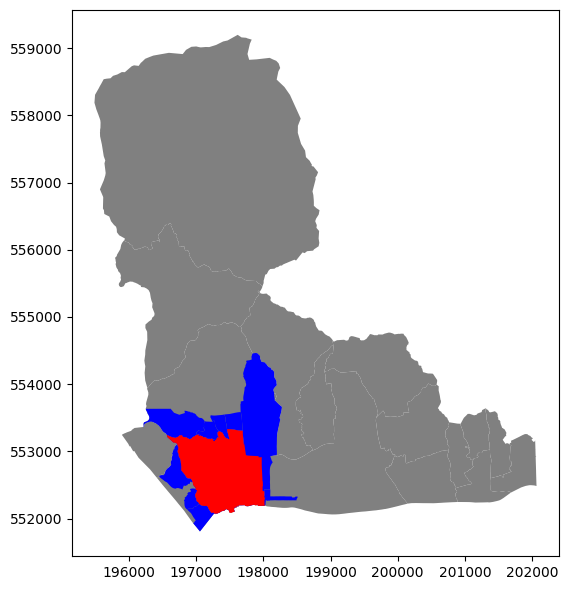

In [32]:
fig, ax = plt.subplots(figsize=(6,6))


gdf = gpd.GeoDataFrame(base_tmp, geometry=base_tmp["geometry"])
gdf.plot(ax=ax, color="grey", label="included")

gdf = gpd.GeoDataFrame(bdong_tmp, geometry=bdong_tmp["geometry"])
gdf.plot(ax=ax, color="blue", label="included")

gdf = gpd.GeoDataFrame(hdong_tmp, geometry=hdong_tmp["geometry"])
gdf.plot(ax=ax, color="red", label="main")
fig.tight_layout()
# ax.set_title()

In [33]:
# save
import json

In [34]:
with open("./data/preproc_data/행정동_법정동_매퍼/by_intersection/bdong2hdong_dict.json", "w") as f:
    json.dump(bdong2hdong_dict, f, indent=4, ensure_ascii=False)

with open("./data/preproc_data/행정동_법정동_매퍼/by_intersection/hdong2bdong_dict.json", "w") as f:
    json.dump(hdong2bdong_dict, f, indent=4, ensure_ascii=False)

In [35]:
bdong2hdong_df.reset_index(drop=True).to_csv(
    "./data/preproc_data/행정동_법정동_매퍼/by_intersection/bdong2hdong_df.csv", index=False
)
hdong2bdong_df.reset_index(drop=True).to_csv(
    "./data/preproc_data/행정동_법정동_매퍼/by_intersection/hdong2bdong_df.csv", index=False
)

In [36]:
bdong = bdong_shp_df.copy()
hdong = hdong_shp_df.copy()

In [37]:
bdong["total_name"] = bdong["rough_name"] + "_" + bdong["detail_name"]
bdong_code_name_dict = bdong.set_index("detail_code")["total_name"].to_dict()

In [38]:
hdong["total_name"] = hdong["rough_name"] + "_" + hdong["detail_name"]
hdong_code_name_dict = hdong.set_index("detail_code")["total_name"].to_dict()

In [39]:
with open("./data/preproc_data/행정동_법정동_매퍼/bdong_code_name_dict.json", "w") as f:
    json.dump(bdong_code_name_dict, f, indent=4, ensure_ascii=False)

with open("./data/preproc_data/행정동_법정동_매퍼/hdong_code_name_dict.json", "w") as f:
    json.dump(hdong_code_name_dict, f, indent=4, ensure_ascii=False)

In [40]:
bdong2hdong_df["bdong_name"] = bdong2hdong_df["bdong"].map(bdong_code_name_dict)
bdong2hdong_df["hdong_name"] = bdong2hdong_df["hdong"].map(hdong_code_name_dict)

In [41]:
hdong2bdong_df["hdong_name"] = hdong2bdong_df["hdong"].map(hdong_code_name_dict)
hdong2bdong_df["bdong_name"] = hdong2bdong_df["bdong"].map(bdong_code_name_dict)

In [42]:
hdong2bdong_df

,hdong,bdong,hdong_name,bdong_name
0,11010530,11110105,서울특별시_종로구_사직동,서울특별시_종로구_창성동
0,11010530,11110106,서울특별시_종로구_사직동,서울특별시_종로구_통의동
0,11010530,11110107,서울특별시_종로구_사직동,서울특별시_종로구_적선동
0,11010530,11110108,서울특별시_종로구_사직동,서울특별시_종로구_통인동
0,11010530,11110109,서울특별시_종로구_사직동,서울특별시_종로구_누상동
...,...,...,...,...
3527,31110522,41290102,경기도_과천시_원문동,경기도_과천시_문원동
3527,31110522,41290103,경기도_과천시_원문동,경기도_과천시_갈현동
3527,31110522,41290107,경기도_과천시_원문동,경기도_과천시_중앙동
3527,31110522,41290108,경기도_과천시_원문동,경기도_과천시_원문동


In [43]:
bdong2hdong_df[bdong2hdong_df["bdong_name"].apply(lambda x: x.startswith("서울특별시_종로구"))]

,bdong,hdong,bdong_name,hdong_name
1318,11110101,11010540,서울특별시_종로구_청운동,서울특별시_종로구_삼청동
1318,11110101,11010550,서울특별시_종로구_청운동,서울특별시_종로구_부암동
1318,11110101,11010720,서울특별시_종로구_청운동,서울특별시_종로구_청운효자동
1319,11110102,11010720,서울특별시_종로구_신교동,서울특별시_종로구_청운효자동
1320,11110103,11010720,서울특별시_종로구_궁정동,서울특별시_종로구_청운효자동
...,...,...,...,...
1403,11110186,11010550,서울특별시_종로구_신영동,서울특별시_종로구_부암동
1403,11110186,11010560,서울특별시_종로구_신영동,서울특별시_종로구_평창동
1404,11110187,11010570,서울특별시_종로구_무악동,서울특별시_종로구_무악동
1404,11110187,11010720,서울특별시_종로구_무악동,서울특별시_종로구_청운효자동
